In [20]:
import os
import json
from typing import List, Dict
import random

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from PIL import Image

from torch.utils.data import Dataset
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix, f1_score

import torchvision.models as models
from torchsummary import summary

import time

## I. Data Handling

In [ ]:
albumIndexes = {}
artistIndexes = {}

def getAlbumIndex(albumID: str):
    if (albumID not in albumIndexes):
        albumIndexes[albumID] = len(albumIndexes)
    return albumIndexes[albumID]

def getArtistIndex(artistID: str):
    if (artistID not in artistIndexes):
        artistIndexes[artistID] = len(artistIndexes)
    return artistIndexes[artistID]

class CustomDataset(Dataset):
    def __init__(self, rootDirs: list[str], transform=None):
        """
        Custom dataset to provide both album and artist labels.

        Args:
            rootDir (str): Root directory containing the data.
            transform: Image transformations to apply.
        """
        self.rootDirs = rootDirs
        self.transform = transform
        self.data = []  # List of tuples (image_path, album_label)
        self.albumLabels = {}  # Mapping from album ID to index
        self.reverseAlbumLabels = {}  # Reverse mapping from index to album ID
        self.artistLabels = {}  # Mapping from artist ID to index
        self.reverseArtistLabels = {}  # Reverse mapping from index to artist ID
        self._prepareDataset()

    def _prepareDataset(self):
        """
        Prepares the dataset by mapping images to album and artist labels.
        """

        for rootDir in self.rootDirs:

            for artistName in os.listdir(rootDir):
                artistPath = os.path.join(rootDir, artistName)
                if os.path.isdir(artistPath):

                    # Assign a unique label to each artist
                    if (artistName not in self.artistLabels):
                        artistIndex = getArtistIndex(artistName)
                        self.artistLabels[artistName] = artistIndex
                        self.reverseArtistLabels[artistIndex] = artistName

                    for albumName in os.listdir(artistPath):
                        albumPath = os.path.join(artistPath, albumName)
                        if (os.path.isdir(albumPath)):
                            # Assign a unique label to each album
                            albumID = f"{artistName}/{albumName}"
                            if (albumID not in self.albumLabels):
                                albumIndex = getAlbumIndex(albumID)
                                self.albumLabels[albumID] = albumIndex
                                self.reverseAlbumLabels[albumIndex] = albumID

                            for imgName in os.listdir(albumPath):
                                imgPath = os.path.join(albumPath, imgName)
                                if (imgPath.endswith(('.png', '.jpg', '.jpeg'))):
                                    self.data.append((
                                        imgPath,
                                        self.albumLabels[albumID],
                                        self.artistLabels[artistName]
                                    ))

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        imgPath, albumLabel, artistLabel = self.data[idx]
        image = Image.open(imgPath).convert('RGB')  # Ensure RGB format
        if self.transform:
            image = self.transform(image)
        return image, (albumLabel, artistLabel)


In [22]:
globalTransforms = [
    # ensure images are of uniform size
    # this is necessary for the neural network to be able to process the images
    transforms.Resize((224, 224)),

    # ensure the end result is a tensor
    # this converts the image from [0,255] to [0,1]
    # making it compatible with the neural network
    transforms.ToTensor(),

    # normalise the data
    transforms.Normalize(
        # this is the mean and standard deviation of the ImageNet dataset
        # the pixel value, for each channel, is subtracted by the mean and divided by the standard deviation
        # this should shift the pixel values to be centred around zero (mean: 0, std: 1)
        # this allows faster and more stable convergence during optimisation
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
]

globalTransformer = transforms.Compose(globalTransforms)

# LOAD DATASET
rootDir = globals()['_dh'][0] # os.path.dirname(os.path.abspath(__file__))
dataDir = os.path.join(rootDir, '..', 'data')

trainDirs = [
    os.path.join(dataDir, 'art_'),
    os.path.join(dataDir, 'art_a_dig'),
    os.path.join(dataDir, 'art_b_phys'),
    os.path.join(dataDir, 'art_c_dig'),
]

dataset = CustomDataset(rootDirs=trainDirs, transform=globalTransformer)

with open(os.path.join(dataDir, 'manifest.json'), 'r', encoding='utf-8') as f:
    trueClasses = json.load(f)

for i in range(5):
    print({
        dataset.data[i][0]: dataset.reverseAlbumLabels[dataset.data[i][1]],
    })
print(len(dataset))
print(len(trueClasses))

{'d:\\Programming\\UoM\\virtual-turntable\\server\\modelling\\sandbox\\..\\data\\art_\\_null\\_null\\null.jpg': '_null/_null'}
{'d:\\Programming\\UoM\\virtual-turntable\\server\\modelling\\sandbox\\..\\data\\art_a_dig\\ArcadeFire\\Funeral_ArcadeFire_2004\\front.png': 'ArcadeFire/Funeral_ArcadeFire_2004'}
{'d:\\Programming\\UoM\\virtual-turntable\\server\\modelling\\sandbox\\..\\data\\art_a_dig\\ArcadeFire\\TheSuburbs_ArcadeFire_2010\\front.png': 'ArcadeFire/TheSuburbs_ArcadeFire_2010'}
{"d:\\Programming\\UoM\\virtual-turntable\\server\\modelling\\sandbox\\..\\data\\art_a_dig\\ArcticMonkeys\\WhateverPeopleSayIAm,That'sWhatI'mNot_ArcticMonkeys_2006\\front.png": "ArcticMonkeys/WhateverPeopleSayIAm,That'sWhatI'mNot_ArcticMonkeys_2006"}
{'d:\\Programming\\UoM\\virtual-turntable\\server\\modelling\\sandbox\\..\\data\\art_a_dig\\Björk\\Homogenic_Björk_1997\\back.png': 'Björk/Homogenic_Björk_1997'}
196
131


In [23]:
print(len(albumIndexes))
print(len(artistIndexes))

131
101


Note: Data augmentation should be done in the future, to create a more robust dataset.

In [24]:
# VERIFY DATASET INTREGRITY
error = False
for i in range(len(dataset)):
    try:
        img, label = dataset[i]
    except OSError as e:
        error = True
        print(trueClasses[dataset.albumLabels[label + 1]])

if (error):
    raise Exception('Dataset is corrupted')

In [25]:
artDir_test = os.path.join(dataDir, 'art_c_phys')
artDir_testArtist = os.path.join(dataDir, 'art_2h')
testDataset = CustomDataset(rootDirs=[artDir_test, artDir_testArtist], transform=globalTransformer)
print(len(testDataset))

18


In [26]:
# SPLIT DATA
trainLoader = DataLoader(dataset, batch_size=8, shuffle=True)
validationLoader = DataLoader(testDataset, batch_size=8, shuffle=True)

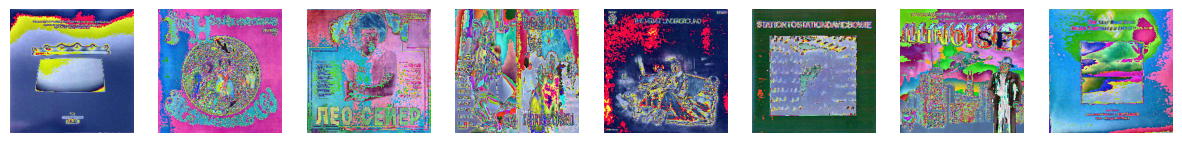

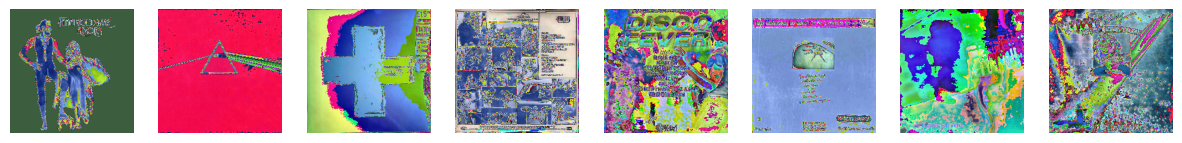

In [27]:
def showBatch(images):
    # Plot the images in the batch
    _, axes = plt.subplots(1, len(images), figsize=(15, 5))
    for ii, image in enumerate(images):
        # Apply denormalization if necessary
        image = transforms.ToPILImage()(image)  # Convert to PIL image for display
        axes[ii].imshow(image)
        axes[ii].axis('off')
    plt.show()

for i, (images, _) in enumerate(trainLoader):
    showBatch(images)
    if (i >= 1):
        break

## II. Model

In [28]:

class ResNetTwoHeaded(nn.Module):

    def __init__(self, numAlbums: int, numArtists: int, numLayers: int = 1):
        super().__init__()

        # Load a ResNet-18 model pretrained on ImageNet
        weights = models.ResNet18_Weights.IMAGENET1K_V1
        self.resnet = models.resnet18(weights=weights)

        # Freeze early layers
        for param in self.resnet.parameters():
            param.requires_grad = False

        # Get input features of original FC layer
        inFeatures = self.resnet.fc.in_features

        # Remove the original fully connected layer
        self.resnet.fc = nn.Identity()

        # Define two new output heads
        self.albumHead = nn.Linear(inFeatures, numAlbums)
        self.artistHead = nn.Linear(inFeatures, numArtists)

        # Unfreeze selected layers for fine-tuning
        if (numLayers >= 1):
            for param in self.resnet.layer4.parameters():
                param.requires_grad = True
        if (numLayers >= 2):
            for param in self.resnet.layer3.parameters():
                param.requires_grad = True
        if (numLayers >= 3):
            for param in self.resnet.layer2.parameters():
                param.requires_grad = True
        if (numLayers >= 4):
            for param in self.resnet.layer1.parameters():
                param.requires_grad = True

    def forward(self, x):
        x = self.resnet(x)
        albumOut = self.albumHead(x)
        artistOut = self.artistHead(x)
        return albumOut, artistOut

model = ResNetTwoHeaded(numAlbums=len(albumIndexes), numArtists=len(artistIndexes), numLayers=1)
summary(model, input_size=(3, 224, 224))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

In [29]:
for name, param in model.named_parameters():
    print(name)


resnet.conv1.weight
resnet.bn1.weight
resnet.bn1.bias
resnet.layer1.0.conv1.weight
resnet.layer1.0.bn1.weight
resnet.layer1.0.bn1.bias
resnet.layer1.0.conv2.weight
resnet.layer1.0.bn2.weight
resnet.layer1.0.bn2.bias
resnet.layer1.1.conv1.weight
resnet.layer1.1.bn1.weight
resnet.layer1.1.bn1.bias
resnet.layer1.1.conv2.weight
resnet.layer1.1.bn2.weight
resnet.layer1.1.bn2.bias
resnet.layer2.0.conv1.weight
resnet.layer2.0.bn1.weight
resnet.layer2.0.bn1.bias
resnet.layer2.0.conv2.weight
resnet.layer2.0.bn2.weight
resnet.layer2.0.bn2.bias
resnet.layer2.0.downsample.0.weight
resnet.layer2.0.downsample.1.weight
resnet.layer2.0.downsample.1.bias
resnet.layer2.1.conv1.weight
resnet.layer2.1.bn1.weight
resnet.layer2.1.bn1.bias
resnet.layer2.1.conv2.weight
resnet.layer2.1.bn2.weight
resnet.layer2.1.bn2.bias
resnet.layer3.0.conv1.weight
resnet.layer3.0.bn1.weight
resnet.layer3.0.bn1.bias
resnet.layer3.0.conv2.weight
resnet.layer3.0.bn2.weight
resnet.layer3.0.bn2.bias
resnet.layer3.0.downsample.0.w

In [30]:
for name, param in model.named_parameters():
    if (param.requires_grad):
        print(name)


resnet.layer4.0.conv1.weight
resnet.layer4.0.bn1.weight
resnet.layer4.0.bn1.bias
resnet.layer4.0.conv2.weight
resnet.layer4.0.bn2.weight
resnet.layer4.0.bn2.bias
resnet.layer4.0.downsample.0.weight
resnet.layer4.0.downsample.1.weight
resnet.layer4.0.downsample.1.bias
resnet.layer4.1.conv1.weight
resnet.layer4.1.bn1.weight
resnet.layer4.1.bn1.bias
resnet.layer4.1.conv2.weight
resnet.layer4.1.bn2.weight
resnet.layer4.1.bn2.bias
albumHead.weight
albumHead.bias
artistHead.weight
artistHead.bias


## III. Training

In [33]:

def train(
    model, trainLoader, validationLoader, maxEpochs=5, learningRate=0.001, weightDecay=1e-4,
    patience=4, overallBestValLoss=0,
):
    """
    Train the model and evaluate on validation data each epoch.
    """
    print('\n', f'Training... (α={learningRate}, λ={weightDecay}, B={trainLoader.batch_size})')

    # LOSS FUNCTION
    # used to compute the error between the model's predictions and the true labels
    criterion = nn.CrossEntropyLoss()

    # OPTIMISER
    # updates the model's weights, based on gradients
    optimiser = optim.Adam(
        filter(lambda p: p.requires_grad, model.parameters()),
        lr=learningRate, weight_decay=weightDecay,
    )

    bestValLoss = float('inf')
    epochsSinceBest = 0

    for epoch in range(maxEpochs):

        # Training phase
        model.train()
        runningLoss = 0.0
        correct, total = 0, 0

        for images, (albumLabels, artistLabels) in trainLoader:
            optimiser.zero_grad()

            albumOutputs, artistOutputs = model(images)

            albumLoss = criterion(albumOutputs, albumLabels)
            artistLoss = criterion(artistOutputs, artistLabels)
            totalLoss = albumLoss + artistLoss

            totalLoss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0) # prevent exploding gradients
            optimiser.step()

            runningLoss += totalLoss.item()
            _, albumPredicted = torch.max(albumOutputs, 1)
            _, artistPredicted = torch.max(artistOutputs, 1)

            total += albumLabels.size(0) + artistLabels.size(0)
            correct += (albumPredicted == albumLabels).sum().item() + (artistPredicted == artistLabels).sum().item()

        trainLoss = runningLoss / len(trainLoader)
        trainAccuracy = correct / total

        # Validation phase
        model.eval()
        valLoss = 0.0
        valCorrect, valTotal = 0, 0

        with torch.no_grad():
            for images, (albumLabels, artistLabels) in validationLoader:

                albumOutputs, artistOutputs = model(images)

                albumLoss = criterion(albumOutputs, albumLabels)
                artistLoss = criterion(artistOutputs, artistLabels)
                totalLoss = albumLoss + artistLoss

                valLoss += totalLoss.item()

                _, albumPredicted = torch.max(albumOutputs, 1)
                _, artistPredicted = torch.max(artistOutputs, 1)

                valTotal += albumLabels.size(0) + artistLabels.size(0)
                valCorrect += (albumPredicted == albumLabels).sum().item() + (artistPredicted == artistLabels).sum().item()

        valLoss /= len(validationLoader)
        valAccuracy = valCorrect / valTotal

        print(
            f"(Epoch {epoch+1}) "
            f"Train Loss: {trainLoss:.4f}, Train Accuracy: {trainAccuracy:.4f} || "
            f"Val Loss: {valLoss:.4f}, Val Accuracy: {valAccuracy:.4f}"
        )

        # early stopping
        if (valLoss < bestValLoss):
            bestValLoss = valLoss
            epochsSinceBest = 0

            if (valLoss < overallBestValLoss):
                overallBestValLoss = valLoss
                torch.save({
                    'epoch': epoch + 1,
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimiser.state_dict(),
                    'val_loss': valLoss,
                }, f'resnet_2({overallBestValLoss}).pt')
        else:
            epochsSinceBest += 1

        if (epochsSinceBest >= patience):
            print('Early stopping triggered!')
            break

    return overallBestValLoss

model = ResNetTwoHeaded(numAlbums=len(albumIndexes), numArtists=len(artistIndexes), numLayers=2)
train(model, trainLoader, validationLoader, maxEpochs=25, learningRate=1e-4, weightDecay=1e-3)



 Training... (α=0.0001, λ=0.001, B=8)
(Epoch 1) Train Loss: 9.9889, Train Accuracy: 0.0077 || Val Loss: 9.3954, Val Accuracy: 0.1111
(Epoch 2) Train Loss: 7.4361, Train Accuracy: 0.3418 || Val Loss: 8.3194, Val Accuracy: 0.2778
(Epoch 3) Train Loss: 5.8023, Train Accuracy: 0.7015 || Val Loss: 7.5618, Val Accuracy: 0.3889
(Epoch 4) Train Loss: 4.5508, Train Accuracy: 0.8954 || Val Loss: 6.7973, Val Accuracy: 0.5000
(Epoch 5) Train Loss: 3.5907, Train Accuracy: 0.9566 || Val Loss: 5.4568, Val Accuracy: 0.5278
(Epoch 6) Train Loss: 2.7003, Train Accuracy: 0.9847 || Val Loss: 6.8672, Val Accuracy: 0.6667
(Epoch 7) Train Loss: 2.0252, Train Accuracy: 0.9974 || Val Loss: 5.1244, Val Accuracy: 0.6944
(Epoch 8) Train Loss: 1.5143, Train Accuracy: 1.0000 || Val Loss: 5.2424, Val Accuracy: 0.6944
(Epoch 9) Train Loss: 1.1311, Train Accuracy: 1.0000 || Val Loss: 4.8603, Val Accuracy: 0.6667
(Epoch 10) Train Loss: 0.8336, Train Accuracy: 1.0000 || Val Loss: 4.0103, Val Accuracy: 0.6944
(Epoch 11)

0

## IV. Validation

In [35]:
def validate(model, testImage, printResult = True):
    model.eval()

    with torch.no_grad():
        albumOutputs, artistOutputs = model(testImage)

        albumProbs = torch.nn.functional.softmax(albumOutputs, dim=1)
        albumPredProbs, albumPredClasses = torch.max(albumProbs, 1)
        albumPredID = dataset.reverseAlbumLabels[albumPredClasses.item()]
        albumPredProbs = albumPredProbs.item()

        artistProbs = torch.nn.functional.softmax(artistOutputs, dim=1)
        artistPredProbs, artistPredClasses = torch.max(artistProbs, 1)
        artistPredID = dataset.reverseArtistLabels[artistPredClasses.item()]
        artistPredProbs = artistPredProbs.item()

        if (printResult):
            print(f'Album Prediction: {albumPredID} ({albumPredProbs:.4f})')
            print(f'Artist Prediction: {artistPredID} ({artistPredProbs:.4f})')

    return ((albumPredID, albumPredProbs), (artistPredID, artistPredProbs))


def validateImage(model, imagePath: str, imageWidth = 350, printResult = True):
    testImage = Image.open(imagePath)
    if (imageWidth > 0):
        displayImage(testImage, imageWidth)

    testImage = globalTransformer(testImage)
    testImage = testImage.unsqueeze(0) # add batch dimension, as model expects it

    return validate(model, testImage, printResult)

def displayImage(image: Image, imageWidth = 350):
    aspectRatio = image.height / image.width
    newHeight = int(imageWidth * aspectRatio)
    resizedImage = image.resize((imageWidth, newHeight))
    display(resizedImage)


### Seen Data

When an image is seen by the model, the model should be able to predict the correct label with high accuracy.

In [36]:
import torch
from torch.utils.data import DataLoader
from sklearn.metrics import confusion_matrix, f1_score

def validateDataset(model: torch.nn.Module, dataset: CustomDataset, printResults=False):
    """
    Validates the dataset using the given two-headed model.

    Args:
        model (torch.nn.Module): The trained model to use for validation.
        dataset (CustomDataset): The dataset to validate.
        printResults (bool): Whether to print the results or not.

    Returns:
        dict: A dictionary containing F1 scores and confusion matrices for albums and artists.
    """
    model.eval()

    allTrueAlbums, allPredAlbums = [], []
    allTrueArtists, allPredArtists = [], []

    validationLoader = DataLoader(dataset, batch_size=8, shuffle=False)

    with torch.no_grad():
        for images, (trueAlbums, trueArtists) in validationLoader:  # Expecting tuple (album, artist)
            albumOut, artistOut = model(images)

            predAlbums = albumOut.argmax(dim=1)
            predArtists = artistOut.argmax(dim=1)

            allTrueAlbums.extend(trueAlbums.cpu().numpy())
            allPredAlbums.extend(predAlbums.cpu().numpy())

            allTrueArtists.extend(trueArtists.cpu().numpy())
            allPredArtists.extend(predArtists.cpu().numpy())

    # Compute confusion matrices and F1-scores
    albumConfMatrix = confusion_matrix(allTrueAlbums, allPredAlbums)
    artistConfMatrix = confusion_matrix(allTrueArtists, allPredArtists)

    albumF1 = f1_score(allTrueAlbums, allPredAlbums, average='weighted')
    artistF1 = f1_score(allTrueArtists, allPredArtists, average='weighted')

    if (printResults):
        print("Album Confusion Matrix:\n", albumConfMatrix)
        print(f"Album F1 Score: {albumF1:.4f}")
        print("\nArtist Confusion Matrix:\n", artistConfMatrix)
        print(f"Artist F1 Score: {artistF1:.4f}")

    return (albumF1 + artistF1) / 2

# Example usage
validateDataset(model, dataset, printResults=True)


Album Confusion Matrix:
 [[1 0 0 ... 0 0 0]
 [0 1 0 ... 0 0 0]
 [0 0 1 ... 0 0 0]
 ...
 [0 0 0 ... 2 0 0]
 [0 0 0 ... 0 1 0]
 [0 0 0 ... 0 0 2]]
Album F1 Score: 1.0000

Artist Confusion Matrix:
 [[1 0 0 ... 0 0 0]
 [0 2 0 ... 0 0 0]
 [0 0 1 ... 0 0 0]
 ...
 [0 0 0 ... 2 0 0]
 [0 0 0 ... 0 1 0]
 [0 0 0 ... 0 0 2]]
Artist F1 Score: 1.0000


1.0

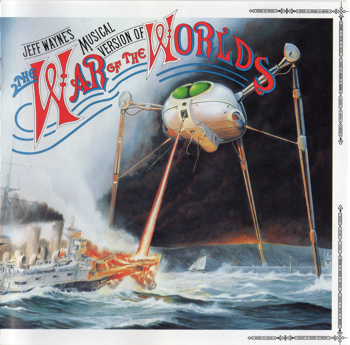

Album Prediction: JeffWayne/JeffWayne'sMusicalVersionofTheWaroftheWorlds_JeffWayne_1978 (0.9999)
Artist Prediction: JeffWayne (1.0000)


(("JeffWayne/JeffWayne'sMusicalVersionofTheWaroftheWorlds_JeffWayne_1978",
  0.9999276399612427),
 ('JeffWayne', 0.9999704360961914))

In [37]:
validateImage(model, os.path.join(rootDir, '..', 'data', 'art_a_dig', 'JeffWayne', "JeffWayne'sMusicalVersionofTheWaroftheWorlds_JeffWayne_1978", 'front.png'))

#### 'Seen' Data

Tyically, a model wants to be generalised to unseen data, so that it can be be robust against any data it comes across.

However, in reality, the application of this roject is that it can be reasonably assumed that only album covers will be seen by the model. This is significant, as it means that the user input data will be _very_ similar to the actual test data. For example, look at the above image (official scan used in training) and the below image (a photo similar to what a user might have). Since they are both of the same album, they are almost identical, except for very small differences (particularly colour).

And, furthermore, as a physcial hardware device, it is likely to only ever service a fairly small number of albums in the user's collection.

Therefore, the model should be able to predict the correct label with high accuracy, as 'overfitting' to the training data serves the purpose of the project.

In [38]:
validateDataset(model, testDataset, printResults=True)

Album Confusion Matrix:
 [[1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0]
 [0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0]
 [0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0]
 [0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]
Album F1 Score: 0.6852

Artist Confusion Matrix:
 [[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 1 1 0 0 0 0 0

0.6851851851851851

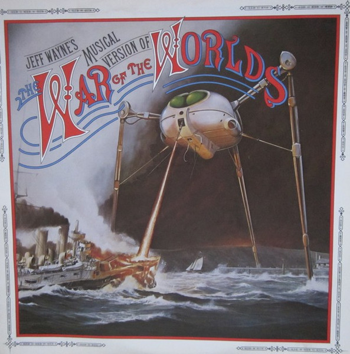

Album Prediction: JeffWayne/JeffWayne'sMusicalVersionofTheWaroftheWorlds_JeffWayne_1978 (0.9929)
Artist Prediction: JeffWayne (0.9948)


(("JeffWayne/JeffWayne'sMusicalVersionofTheWaroftheWorlds_JeffWayne_1978",
  0.9929062128067017),
 ('JeffWayne', 0.994788646697998))

In [39]:
validateImage(model, os.path.join(rootDir, '..', 'data', 'misc', "JeffWayne'sMusicalVersionofTheWaroftheWorlds_JeffWayne(2).png"))

### Unseen Data

Unseen data (the model is not expected to perform well).

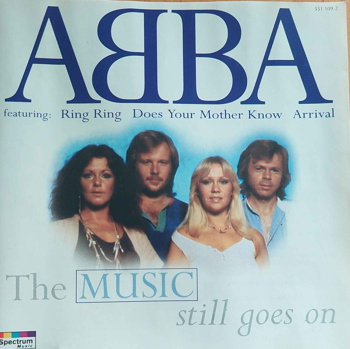

Album Prediction: EltonJohnandCliffRichard/SlowRivers_EltonJohnandCliffRichard_1986 (0.0286)
Artist Prediction: JeffWayne (0.0446)


(('EltonJohnandCliffRichard/SlowRivers_EltonJohnandCliffRichard_1986',
  0.028622953221201897),
 ('JeffWayne', 0.04457102715969086))

In [40]:
validateImage(model, os.path.join(rootDir, '..', 'data', 'misc', 'TheMusicStillGoesOn_ABBA.jpg'))

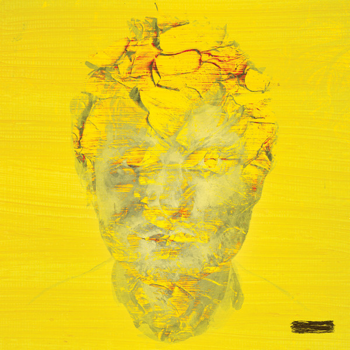

Album Prediction: TheVelvetUnderground/TheVelvetUnderground_TheVelvetUnderground_1969 (0.0616)
Artist Prediction: TheJimiHendrixExperience (0.1098)


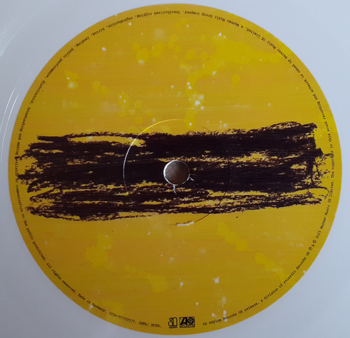

Album Prediction: TheVelvetUnderground&Nico/TheVelvetUnderground&Nico_TheVelvetUnderground&Nico_1967 (0.2305)
Artist Prediction: TheVelvetUnderground&Nico (0.1805)


(('TheVelvetUnderground&Nico/TheVelvetUnderground&Nico_TheVelvetUnderground&Nico_1967',
  0.23046661913394928),
 ('TheVelvetUnderground&Nico', 0.18050599098205566))

In [41]:
validateImage(model, os.path.join(rootDir, '..', 'data', 'art_2h', 'EdSheeran', '−_EdSheeran_2023', 'front.jpg'))
validateImage(model, os.path.join(rootDir, '..', 'data', 'art_2h', 'EdSheeran', '−_EdSheeran_2023', 'alt.jpg'))

Note: the sum of the probabilities will be 1. Therefore, with a small datatset, the model may be confidently wrong (i.e. a high probability for the wrong class), as this is moreso a measure of 'how confident I am it is this, compared to the other options', as opposed to 'how confident I am that it is this, and not anything else'. This is important to note when interpreting the results (we should have a high standard for confidence). However, as the dataset grows, the liklihood of any one class being highly-favoured, when the true result lies outside of the trained classes, should decrease.

#### Bad Data

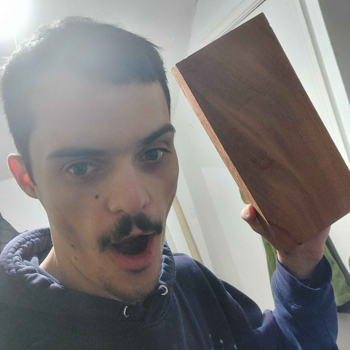

Album Prediction: CliffRichardandSarahBrightman/AllIAskofYou_CliffRichardandSarahBrightman_1986 (0.0421)
Artist Prediction: CliffRichardandSarahBrightman (0.0762)


(('CliffRichardandSarahBrightman/AllIAskofYou_CliffRichardandSarahBrightman_1986',
  0.04211336374282837),
 ('CliffRichardandSarahBrightman', 0.07618759572505951))

In [42]:
validateImage(model, os.path.join(rootDir, '..', 'data', 'misc', 'MahoganyJack.jpg'))

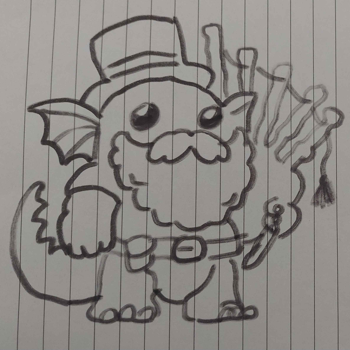

Album Prediction: PinkFloyd/TheWall_PinkFloyd_1979 (0.1349)
Artist Prediction: Reader'sDigest (0.1650)


(('PinkFloyd/TheWall_PinkFloyd_1979', 0.13485093414783478),
 ("Reader'sDigest", 0.1650335192680359))

In [43]:
validateImage(model, os.path.join(rootDir, '..', 'data', 'misc', 'Haranthur.jpg'))

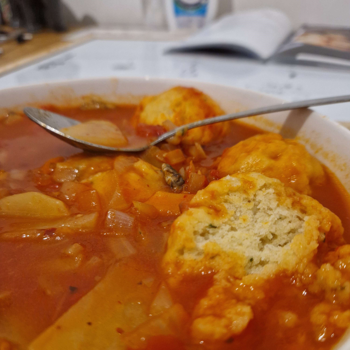

Album Prediction: JeffWayne/JeffWayne'sMusicalVersionofTheWaroftheWorlds_JeffWayne_1978 (0.0404)
Artist Prediction: StevieWonder (0.1258)


(("JeffWayne/JeffWayne'sMusicalVersionofTheWaroftheWorlds_JeffWayne_1978",
  0.04044082388281822),
 ('StevieWonder', 0.12581023573875427))

In [44]:
validateImage(model, os.path.join(rootDir, '..', 'data', 'misc', 'Dumplings.jpg'))

In these examples, we see that the image is (fairly) confidently wrong, about this data, as it has not concept of what is a coverart, and what is not.

The best way to counter this, is to have a confidence threshold. If the model is not confident, it should not make a prediction, without using other fallback methods (e.g. OCR, etc.). As  the dataset increases, the confidence level should naturally decrease for unseen data, as the model will have more data to compare against.

### 'Empty' Data

However, there is one example of bad data that we can theoretically handle quite well: as the camera will be fixed, we have a strong idea of what background to expect. Therefore, we can have one class be trained on the background, whichmeans that when there is 'no data', it will be classified as the background. This will be useful for the 'unseen data' section, as we can see how well the model can differentiate between the background and the other classes.

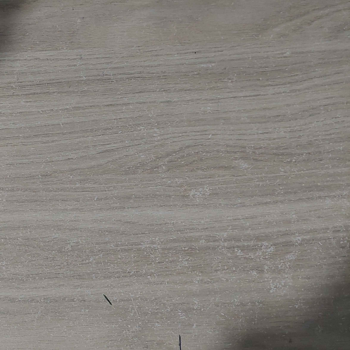

Album Prediction: _null/_null (1.0000)
Artist Prediction: _null (1.0000)


(('_null/_null', 1.0), ('_null', 0.9999998807907104))

In [45]:
validateImage(model, os.path.join(rootDir, '..', 'data', 'art_', '_null', '_null', 'null.jpg'))

## V. Observations

### 1. Model performs better on data belonging to unseen classes.

## VI. Experiments

### 1. How does artificial augmentation improve results?

In [46]:
# Custom dataset to combine original and multiple augmentations
class ArtificiallyAugmentedDataset(CustomDataset):
    def __init__(self, originalDataset, transform, augmentTransform, numAugmentations=4):
        self.originalDataset = originalDataset
        self.transform = transform
        self.augmentTransform = augmentTransform
        self.numAugmentations = numAugmentations

    def __len__(self):
        # Include original images and augmented copies
        return len(self.originalDataset) * (1 + self.numAugmentations)

    def __getitem__(self, idx):

        originalIdx = idx // (1 + self.numAugmentations)
        image, labels = self.originalDataset[originalIdx]

        if ((idx % (1 + self.numAugmentations)) == 0):
            # Return the original image
            transformedImage = self.transform(image)
            return transformedImage, labels

        # Return the augmented image
        augmentedImage = self.augmentTransform(image)
        return augmentedImage, labels


196
980


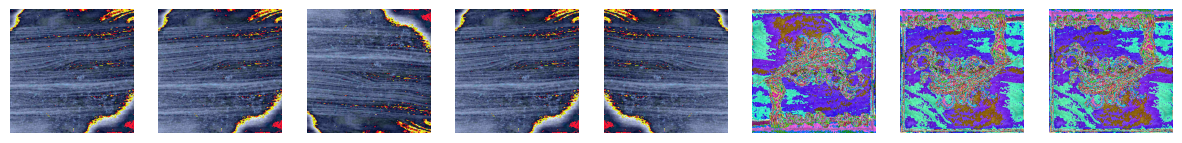

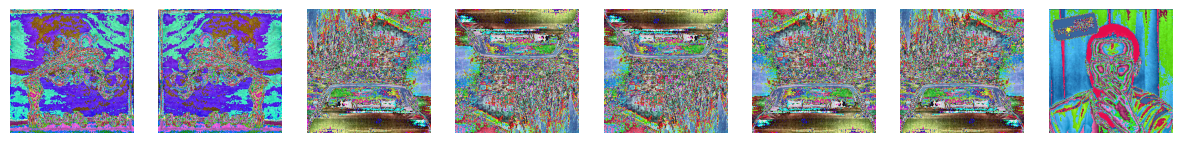

In [47]:
# Example
vanillaDataset = CustomDataset(rootDirs=trainDirs)

augmentedTransforms = [
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
]
augmentedTransformer = transforms.Compose(globalTransforms + augmentedTransforms)

# Initialise the combined dataset with multiple augmentations
augmentedDataset = ArtificiallyAugmentedDataset(vanillaDataset, globalTransformer, augmentedTransformer, numAugmentations=4)

# Define the DataLoader with shuffling
trainLoader = DataLoader(augmentedDataset, batch_size=8, shuffle=False)

print(len(vanillaDataset))
print(len(augmentedDataset))

for i, (images, _) in enumerate(trainLoader):
    showBatch(images)
    if (i >= 1):
        break

In [48]:
artDir_testEx = os.path.join(dataDir, 'art_x')
fullTestDataset = CustomDataset(rootDirs=[artDir_test, artDir_testArtist, artDir_testEx], transform=globalTransformer)
print(len(fullTestDataset))

validateDataset(model, fullTestDataset, printResults=True)

38
Album Confusion Matrix:
 [[0 1 0 1 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 7 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2

0.6829959514170041

#### Combined Augmentations

In [49]:
class RandomFlip(torch.nn.Module):
    """Flip the given image randomly with a given probability.
    If the image is torch Tensor, it is expected
    to have [..., H, W] shape, where ... means an arbitrary number of leading
    dimensions

    Args:
        p (float): probability of the image being flipped. Default value is 0.5
    """

    def __init__(self, p=0.5):
        super().__init__()
        self.p = p

    def forward(self, img):
        """
        Args:
            img (PIL Image or Tensor): Image to be flipped.

        Returns:
            PIL Image or Tensor: Randomly flipped image.
        """
        if torch.rand(1) < self.p:
            return transforms.functional.vflip(
                transforms.functional.hflip(img)
            )
        return img

    def __repr__(self) -> str:
        return f"{self.__class__.__name__}(p={self.p})"

In [51]:
augmentedTransforms = [
    transforms.RandomRotation(30),
    RandomFlip(),
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.1),
    transforms.RandomAffine(10, translate=(0.1, 0.1), shear=5),
    transforms.RandomPerspective(distortion_scale=0.5, p=0.5)
]

augmentedTransformer = transforms.Compose(globalTransforms + augmentedTransforms)
augmentedDataset = ArtificiallyAugmentedDataset(
    vanillaDataset, globalTransformer, augmentedTransformer, 5
)

trainLoader = DataLoader(augmentedDataset, batch_size=64, shuffle=True)

bestValLoss = float('inf')

for learningRate in [1e-5, 1e-4, 1e-3]:
    for weightDecay in [1e-5, 1e-4, 1e-3]:

        augmentedModel = ResNetTwoHeaded(numAlbums=len(albumIndexes), numArtists=len(artistIndexes), numLayers=2)

        bestValLoss = train(
            augmentedModel, trainLoader, validationLoader,
            maxEpochs=20, learningRate=learningRate, weightDecay=weightDecay,
            patience=3, overallBestValLoss=bestValLoss
        )

        validateDataset(augmentedModel, testDataset)
        validateDataset(augmentedModel, fullTestDataset)

print(bestValLoss)



 Training... (α=1e-05, λ=1e-05, B=64)
(Epoch 1) Train Loss: 9.8305, Train Accuracy: 0.0077 || Val Loss: 10.1216, Val Accuracy: 0.0000
(Epoch 2) Train Loss: 9.6331, Train Accuracy: 0.0119 || Val Loss: 10.0831, Val Accuracy: 0.0000
(Epoch 3) Train Loss: 9.4289, Train Accuracy: 0.0149 || Val Loss: 9.8783, Val Accuracy: 0.0000
(Epoch 4) Train Loss: 9.2357, Train Accuracy: 0.0272 || Val Loss: 9.8175, Val Accuracy: 0.0000
(Epoch 5) Train Loss: 9.0476, Train Accuracy: 0.0404 || Val Loss: 9.5633, Val Accuracy: 0.0000
(Epoch 6) Train Loss: 8.8711, Train Accuracy: 0.0459 || Val Loss: 9.6573, Val Accuracy: 0.0000
(Epoch 7) Train Loss: 8.6547, Train Accuracy: 0.0727 || Val Loss: 9.4795, Val Accuracy: 0.0000
(Epoch 8) Train Loss: 8.5014, Train Accuracy: 0.0957 || Val Loss: 9.6827, Val Accuracy: 0.0000
(Epoch 9) Train Loss: 8.3464, Train Accuracy: 0.1220 || Val Loss: 9.1119, Val Accuracy: 0.0000
(Epoch 10) Train Loss: 8.1096, Train Accuracy: 0.1518 || Val Loss: 9.1716, Val Accuracy: 0.0278
(Epoch 1